# 10-6 ResNet for cifar10

## original code is =>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [160]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

## define value tracker

In [3]:
def value_tracker(value_plot, value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=value,
             win = value_plot,
             update='append'
             )

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

## transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

### How to Calculate mean and std in Normalize 

In [133]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)

print(trainset.data.shape)

train_data_mean = trainset.data.mean( axis=(0,1,2) )
train_data_std = trainset.data.std( axis=(0,1,2) )


print(train_data_mean)
print(train_data_std)

train_data_mean = train_data_mean / 255
train_data_std = train_data_std / 255

print(train_data_mean)
print(train_data_std)


Files already downloaded and verified
(50000, 32, 32, 3)
[125.30691805 122.95039414 113.86538318]
[62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [134]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [179]:
trainset[0][0].numpy().shape

(3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


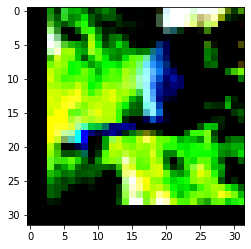

In [184]:
plt.imshow(trainset[6][0].numpy().swapaxes(0,2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


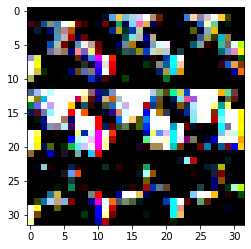

In [185]:
plt.imshow(trainset[6][0].numpy().reshape(32,32,3))

## make ResNet50 

- 모델이 깊어질수록 해달 역전파를 통해 전달되는 Gradients값들이 소실(Vanishing)됨
- 값을 그대로 전달해주는 Skip-connection (Residual)를 고안
- Identity function인 skip-connection은 역전파 시 gradients를 그대로 + 로 그대로 전달해줌

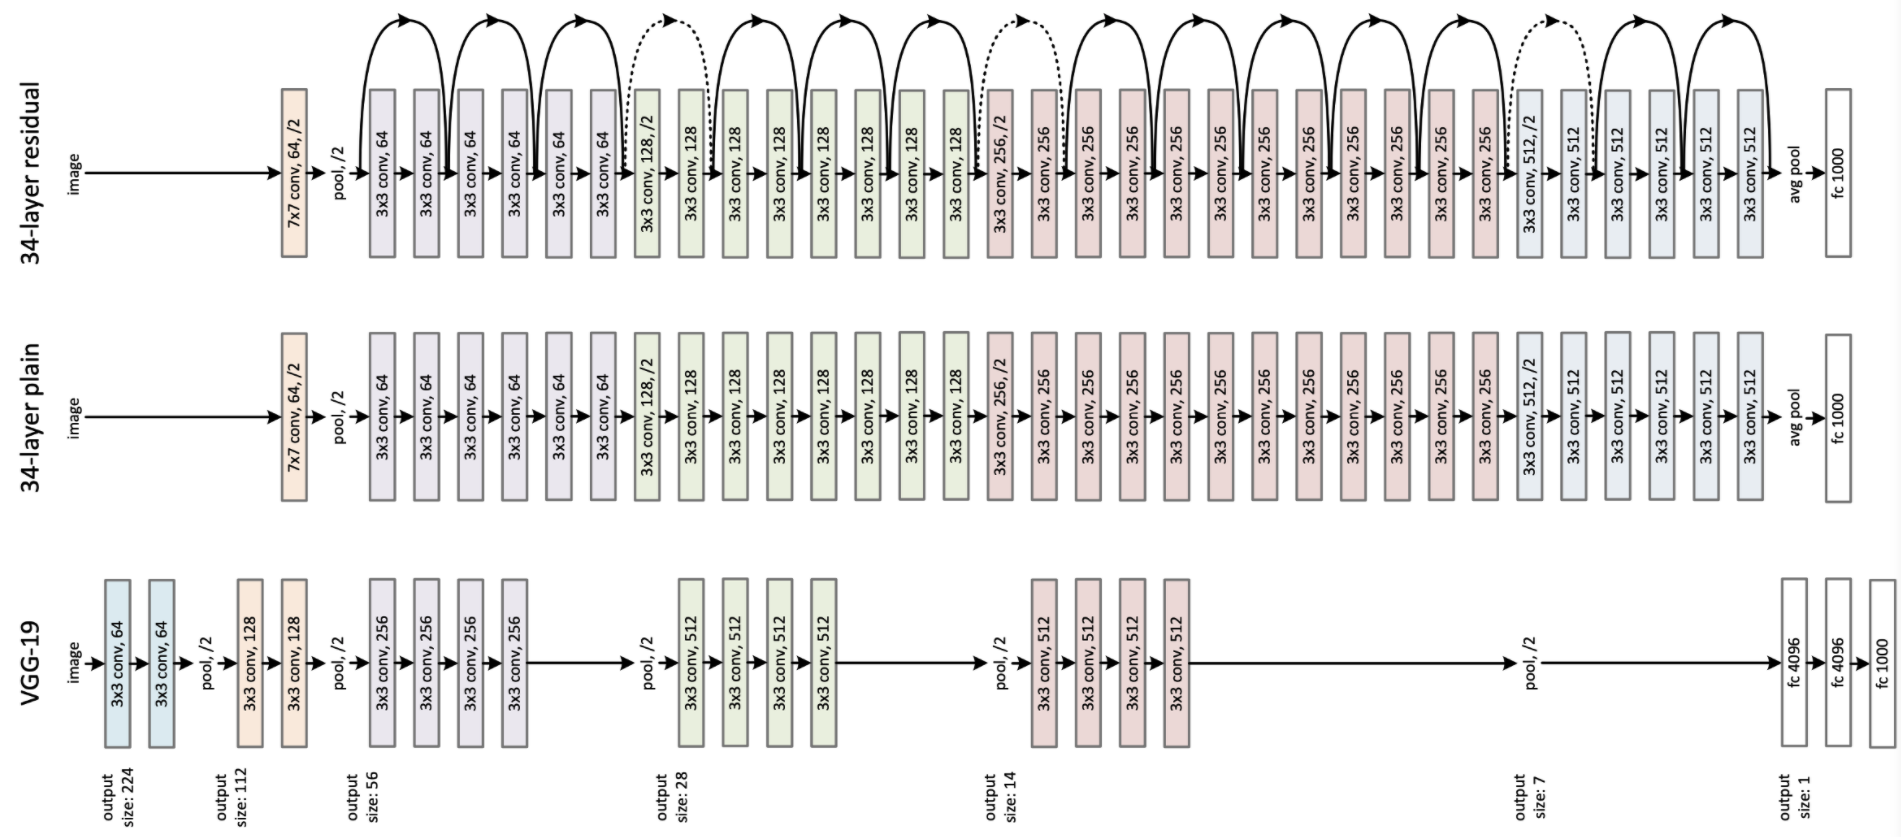

In [7]:
Image('./figures/Lab10_6_ResNet Structure.png')

- Block 단위로 코드가 움직이고 있음
- Basic block은 두 가지의 버젼이 존재함

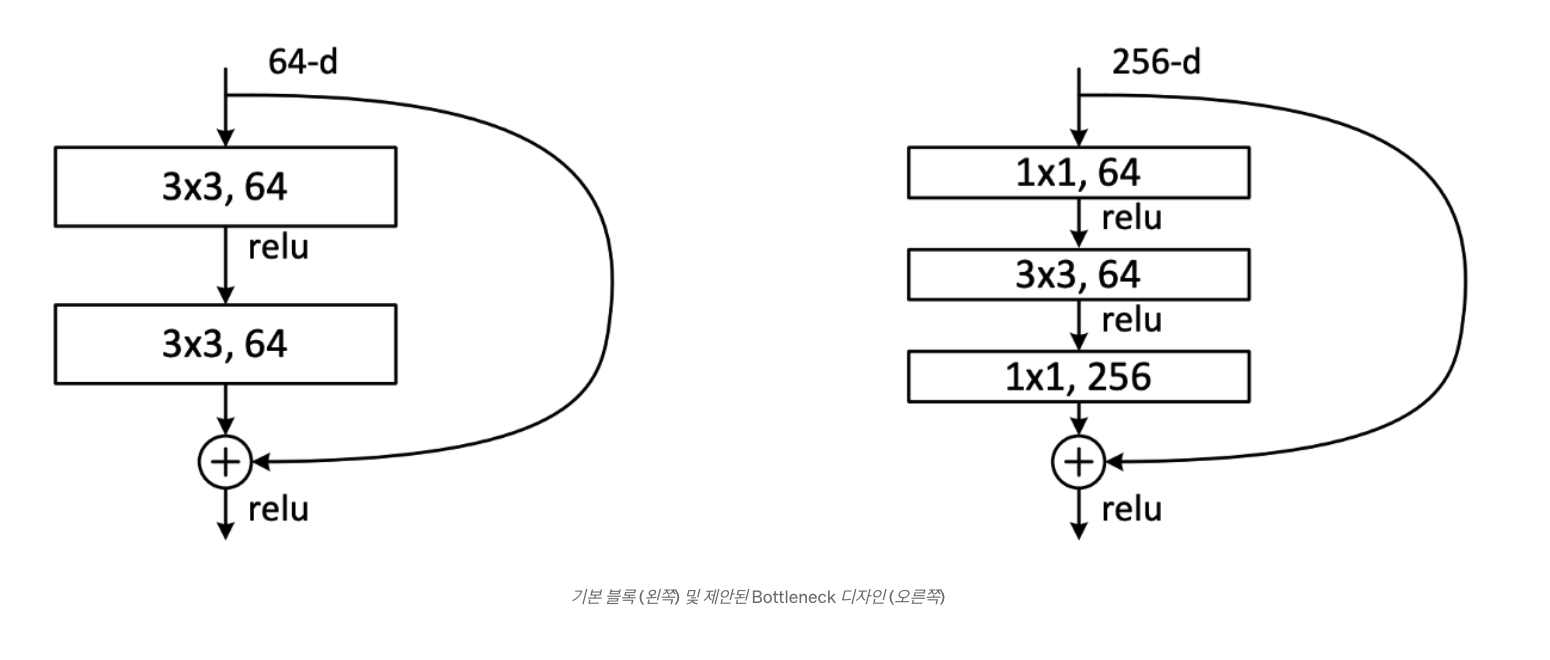

In [8]:
Image('./figures/Lab10_6_Resnet_basic Block.png')

- 실제 논문에서 제안하는 모델의 파라미터 설정을 보자

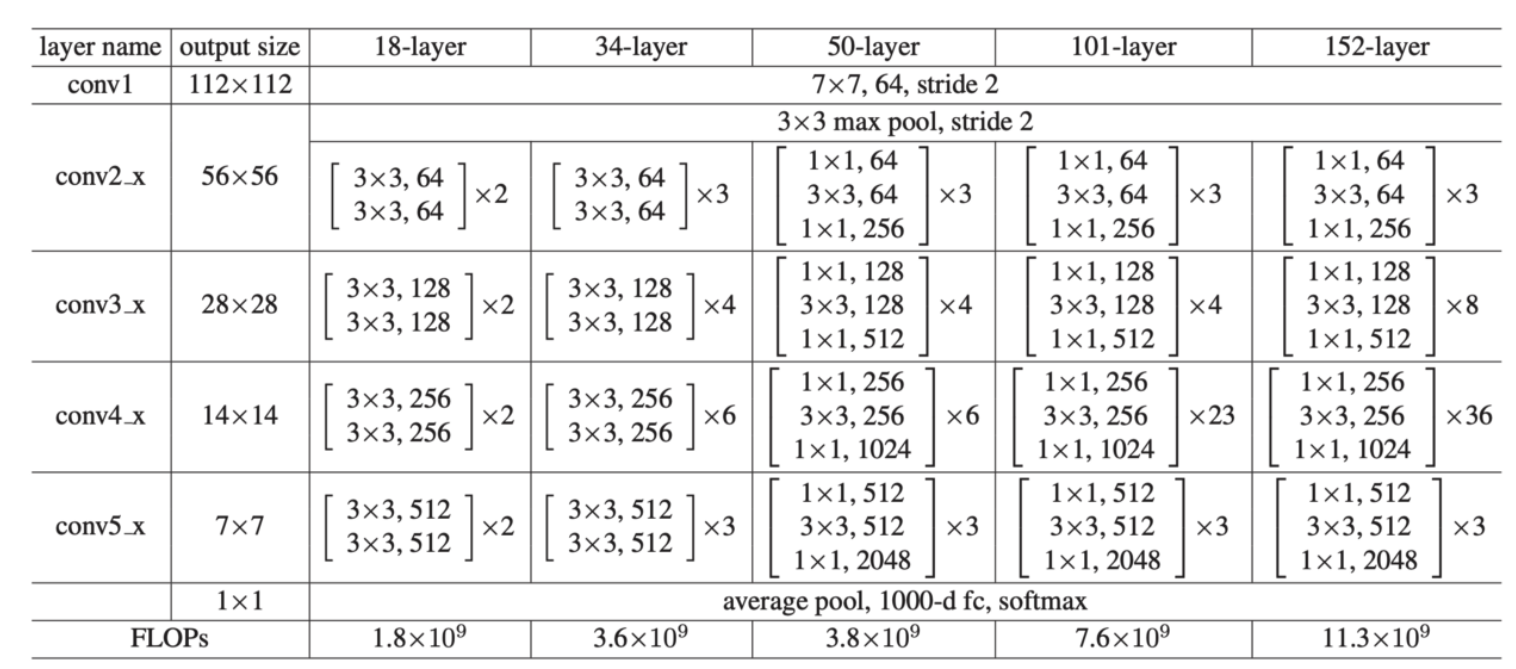

In [9]:
Image('./figures/Lab10_6_parameters.png')
# 3x224x224
torch.nn.Conv2d(3,64,kernel_size=7,padding=3,stride=2)

### Make ResNet without 'make_layers' function
- 우리는 ResNet 50을 만들어보기로 한다

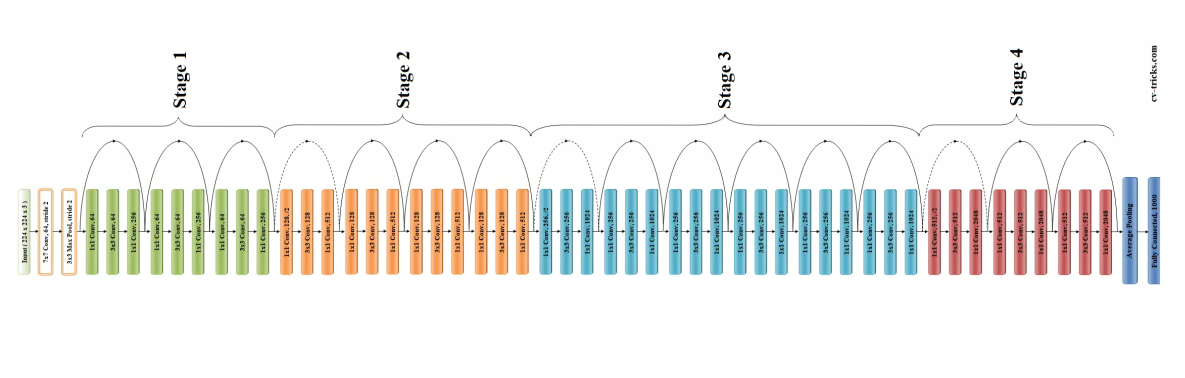

In [10]:
Image('./figures/Lab10-6_resnet50_structure.png')

#### conv module
- [3x3conv -> 1x1 conv] is more efficient than only 3x3 conv

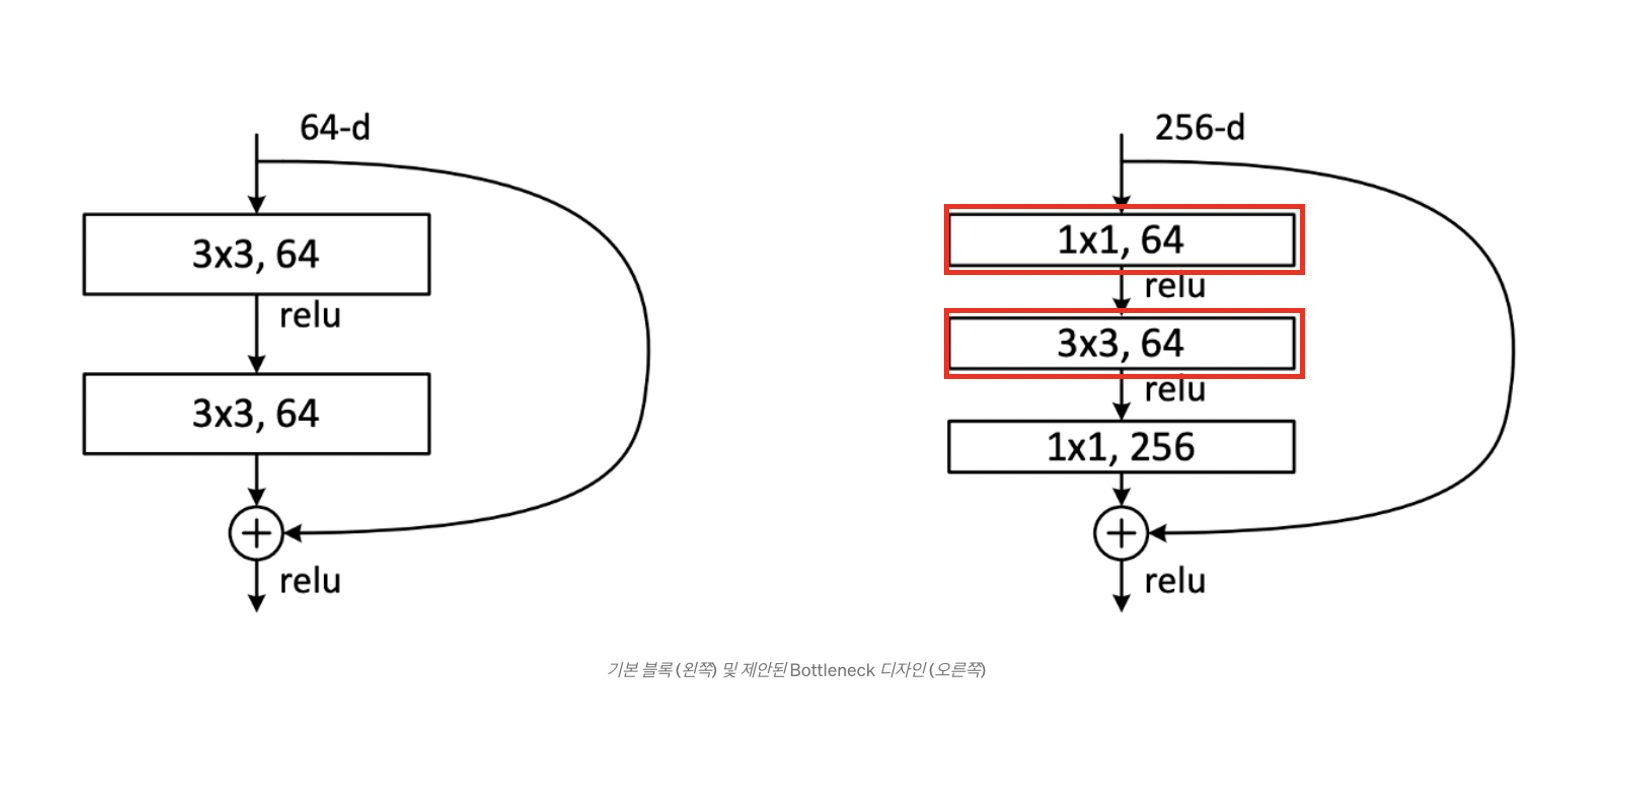

In [11]:
Image('./figures/Lab10_6_build1.png')

In [12]:
class Conv3x3(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
    
    def forward(self,x):
        return self.conv(x)
    
    
class Conv1x1(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False)
    
    def forward(self,x):
        return self.conv(x)

#### basic block

In [13]:
class Basic_block(nn.Module):
    
    def __init__(self,in_channel,out_channel):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        
        self.basic_block = nn.Sequential(
            Conv1x1(in_channel,in_channel),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(),
            Conv3x3(in_channel,in_channel),
            nn.BatchNorm2d(in_channel),
            Conv1x1(in_channel,out_channel)
        )
        
    
    def forward(self,x):
        
        return self.basic_block(x)
        
        
        

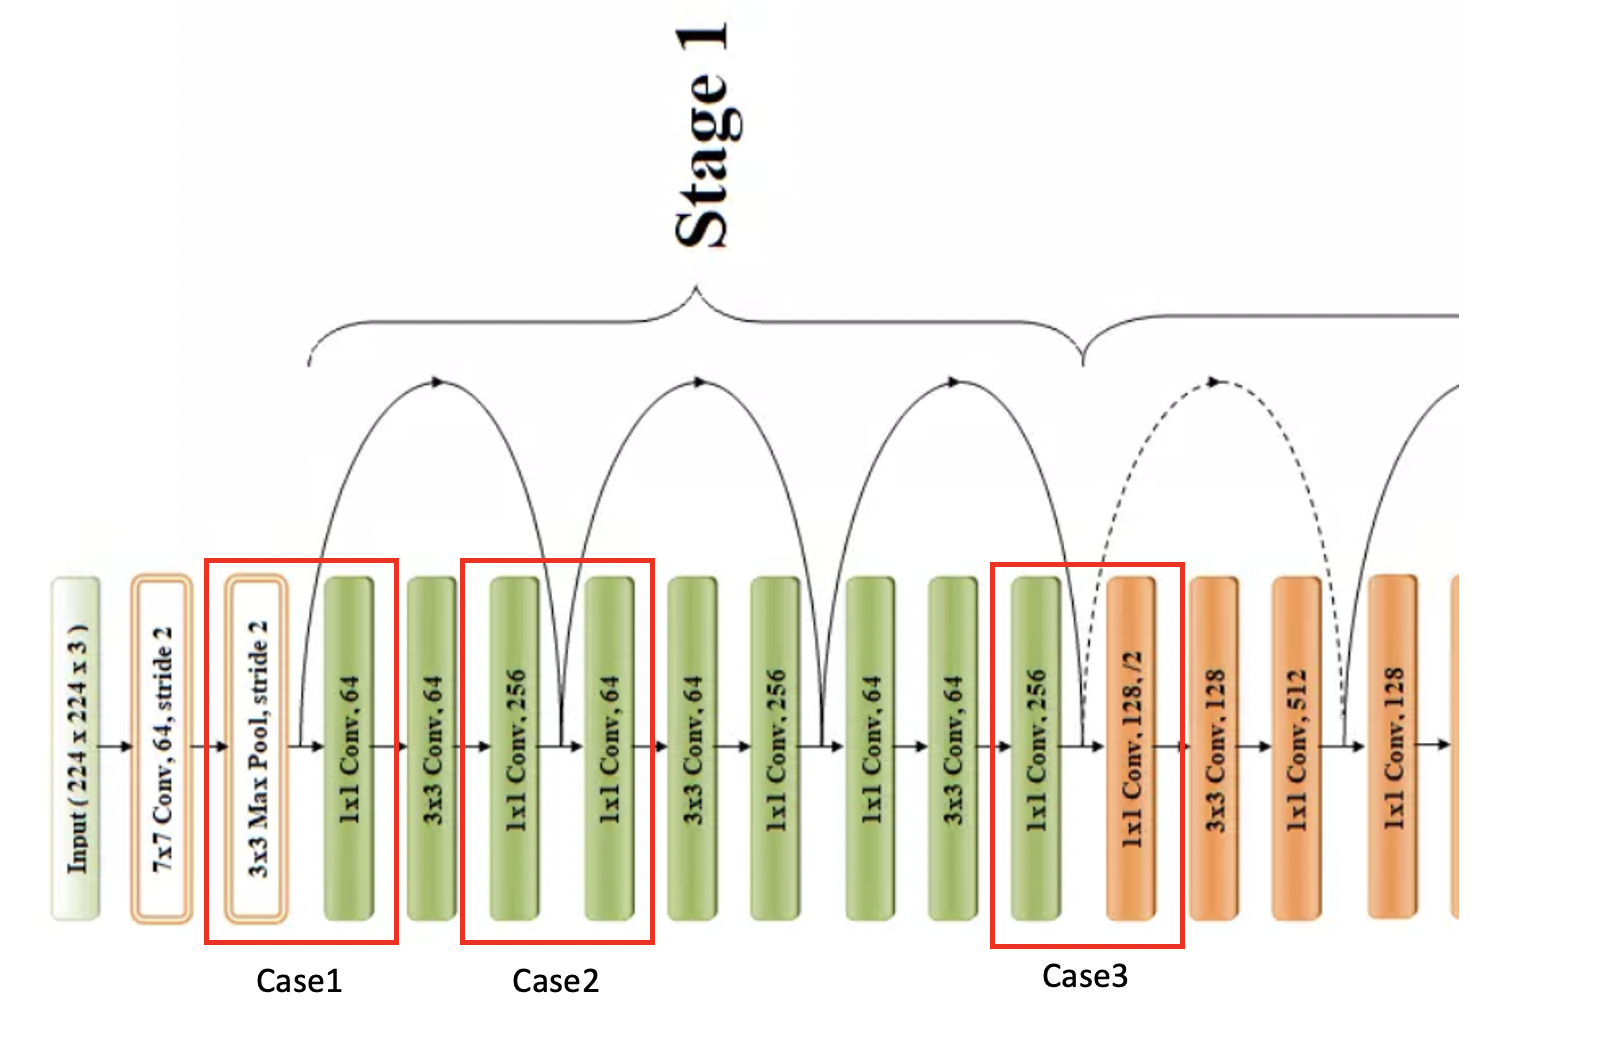

In [104]:
Image('./figures/Lab10-6_resnet50_detail.png')

- [Case1,2] Same data size But  channel size can be changed

In [106]:
class Basic_block(nn.Module):
    
    def __init__(self,before_ch,in_channel,out_channel):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.relu = nn.ReLU()
        self.before_ch = before_ch
        
        if before_ch!=out_channel:
            self.downsample_conv = nn.Conv2d(before_ch,out_channel,kernel_size=1)
        
        
        self.basic_block = nn.Sequential(
            Conv1x1(before_ch,in_channel),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(),
            Conv3x3(in_channel,in_channel),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(),
            Conv1x1(in_channel,out_channel)
        )
        
    
    def forward(self,x):
        origin = x
        out = self.basic_block(x)
        
        if self.before_ch!=self.out_channel:
            origin = self.downsample_conv(x)
        
        out = self.relu(out+origin)
        
        return out
        
        
        

In [187]:
tmp_conv1x1 = nn.Conv2d(in_channels=128,out_channels=32,kernel_size=1)
tmp_input = torch.randn(1,128,64,64)
out = tmp_conv1x1(tmp_input)
print(tmp_input.shape)
print(out.shape)

torch.Size([1, 128, 64, 64])
torch.Size([1, 32, 64, 64])


- [Case3] Both different data size and channel size

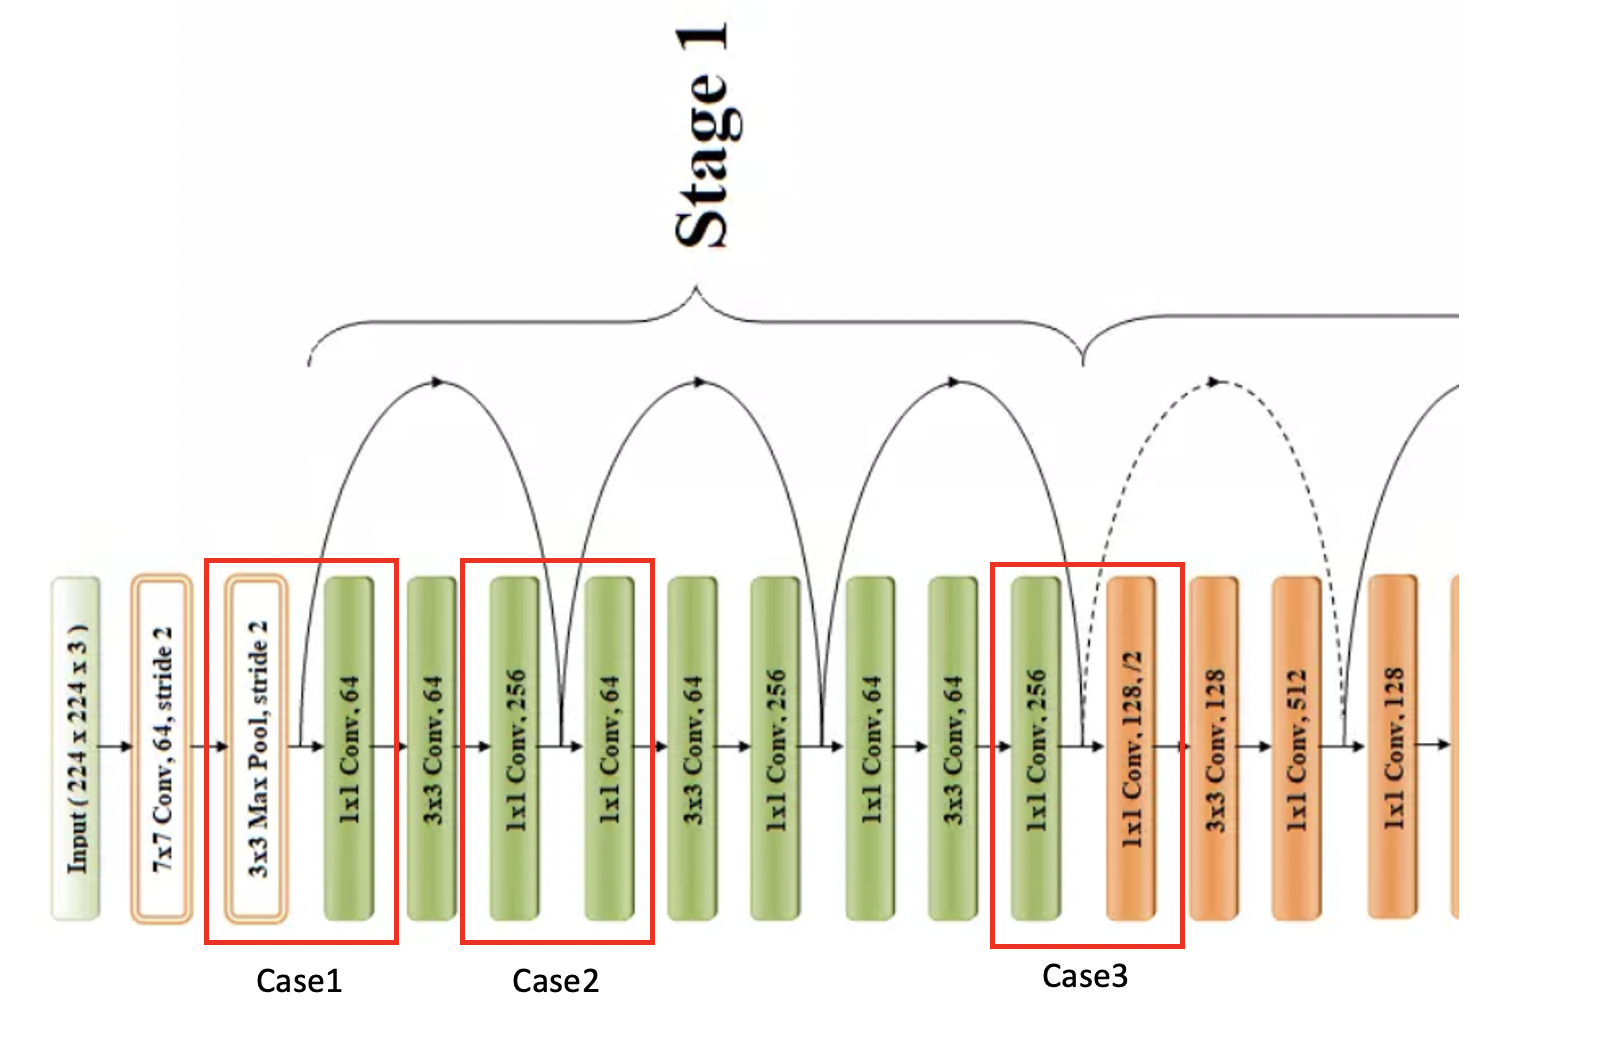

In [108]:
Image('./figures/Lab10-6_resnet50_detail.png')

In [115]:
class Basic_block(nn.Module):
    
    def __init__(self,before_ch,in_channel,out_channel,stride):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.relu = nn.ReLU()
        self.before_ch = before_ch
        
        if before_ch!=out_channel:
            self.downsample_conv = nn.Conv2d(before_ch,out_channel,kernel_size=1,stride=stride) #stride = 2  
        
        
        self.basic_block = nn.Sequential(
            Conv1x1(before_ch,in_channel,stride),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(),
            Conv3x3(in_channel,in_channel),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(),
            Conv1x1(in_channel,out_channel)
        )
        
    
    def forward(self,x):
        origin = x
        out = self.basic_block(x)
        
        if self.before_ch!=self.out_channel:
            origin = self.downsample_conv(origin)
        
        out = self.relu(out+origin)
        
        return out
        
        
        

In [188]:
tmp_conv1x1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=1,stride=2)
tmp_input = torch.randn(1,1,64,64)
out = tmp_conv1x1(tmp_input)
print(tmp_input.shape)
print(out.shape)

torch.Size([1, 1, 64, 64])
torch.Size([1, 32, 32, 32])


#### Build resnet50

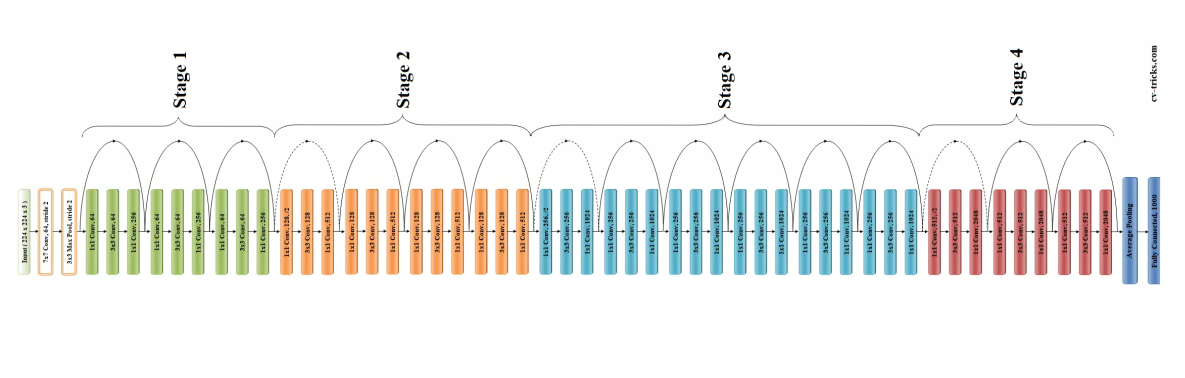

In [117]:
Image('./figures/Lab10-6_resnet50_structure.png')

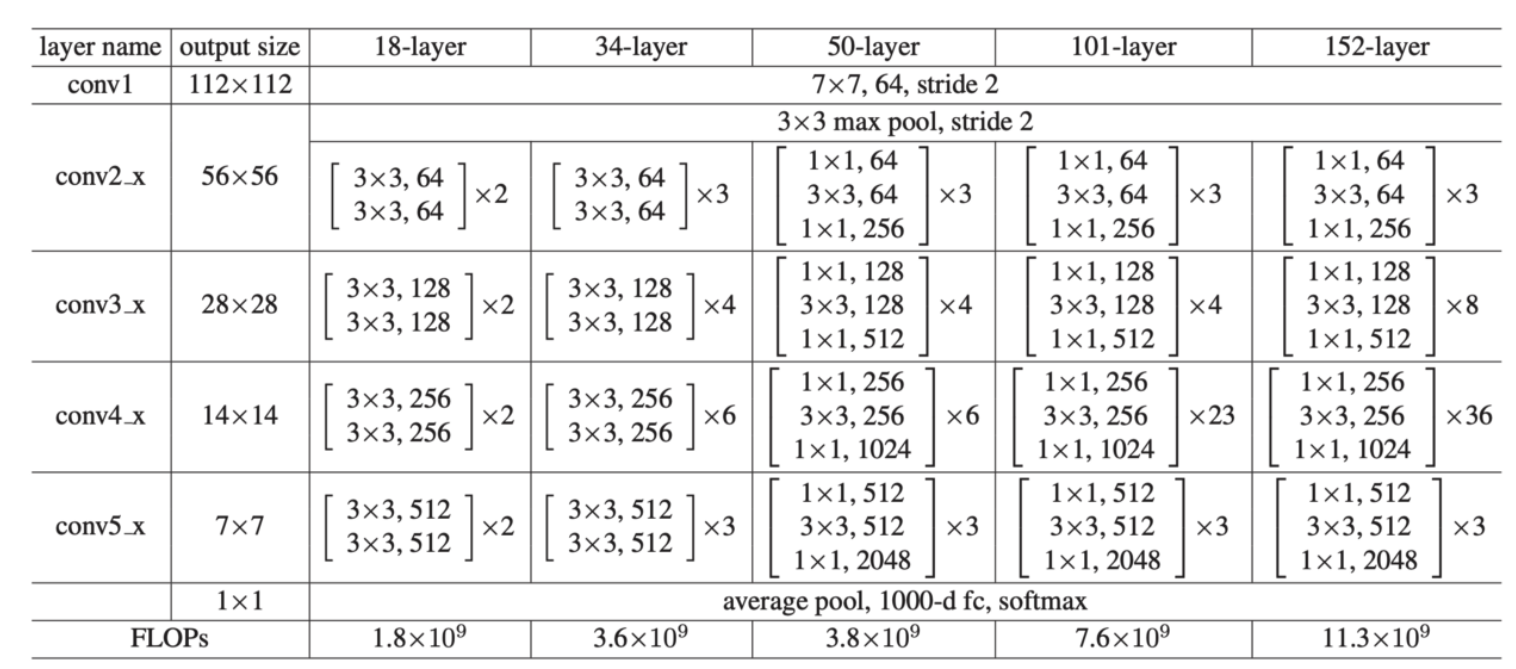

In [118]:
Image('./figures/Lab10_6_parameters.png')

In [149]:
class Resnet50(nn.Module):
    def __init__(self,base_channel=12,n_class):
        super().__init__()
        
        self.conv_first = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False) #예제 데이터 사이즈에 맞추기 위해서 stride=1로 줌
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.stage1 = nn.Sequential(
            Basic_block(64,64,256,stride=1),   # base_channel,base_channel, base_channel*4
            Basic_block(256,64,256,stride=1),
            Basic_block(256,64,256,stride=1)
        )
        
        self.stage2 = nn.Sequential(
            Basic_block(256,128,512,stride=2),
            Basic_block(512,128,512,stride=1),
            Basic_block(512,128,512,stride=1),
            Basic_block(512,128,512,stride=1)
        )
        
        self.stage3 = nn.Sequential(
            Basic_block(512,256,1024,stride=2),
            Basic_block(1024,256,1024,stride=1),
            Basic_block(1024,256,1024,stride=1),
            Basic_block(1024,256,1024,stride=1),
            Basic_block(1024,256,1024,stride=1),
            Basic_block(1024,256,1024,stride=1),
        )
        
        self.stage4 = nn.Sequential(
            Basic_block(1024,512,2048,stride=2),
            Basic_block(2048,512,2048,stride=1),
            Basic_block(2048,512,2048,stride=1),
            Basic_block(2048,512,2048,stride=1),
            Basic_block(2048,512,2048,stride=1),
            Basic_block(2048,512,2048,stride=1),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, n_class)
        
    def forward(self,x):
        batch_size = x.size(0)
        
        x = self.conv_first(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.avgpool(x)
        x = self.fc(x.view(batch_size,-1))
        
        return x

In [189]:
resnet50 = Resnet50(64,10).to(device)

In [190]:
resnet50(torch.randn(1,3,32,32).to(device))

tensor([[ 0.1094,  0.1942, -0.5398, -0.1901,  1.0477,  0.5730,  0.9214, -0.6375,
         -0.1704, -0.1408]], device='cuda:0', grad_fn=<AddmmBackward>)

In [138]:
# resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 10, True).to(device) 
# #1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

# resnet50

# a=torch.Tensor(1,3,32,32).to(device)
# out = resnet50(a)
# print(out)

In [154]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr = 0.0001, momentum = 0.9, weight_decay=5e-4)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

## make plot

In [155]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))
acc_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='Accuracy', legend=['Acc'], showlegend=True))

## define acc_check function

In [156]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' % acc)
    if save:
        torch.save(net.state_dict(), "./model/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

## Training with (acc check + model save)

In [159]:
print(len(trainloader))
epochs = 150

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
    
    #Check Accuracy
    acc = acc_check(resnet50, testloader, epoch, save=1)
    value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')

196
[1,    30] loss: 2.096
[1,    60] loss: 2.045
[1,    90] loss: 2.041
[1,   120] loss: 2.010
[1,   150] loss: 2.002
[1,   180] loss: 1.962
Accuracy of the network on the 10000 test images: 28 %
[2,    30] loss: 1.937
[2,    60] loss: 1.921
[2,    90] loss: 1.917
[2,   120] loss: 1.875
[2,   150] loss: 1.867
[2,   180] loss: 1.837
Accuracy of the network on the 10000 test images: 33 %
[3,    30] loss: 1.795
[3,    60] loss: 1.792
[3,    90] loss: 1.773
[3,   120] loss: 1.773
[3,   150] loss: 1.740
[3,   180] loss: 1.742
Accuracy of the network on the 10000 test images: 37 %
[4,    30] loss: 1.717
[4,    60] loss: 1.701
[4,    90] loss: 1.678
[4,   120] loss: 1.685
[4,   150] loss: 1.684
[4,   180] loss: 1.665
Accuracy of the network on the 10000 test images: 39 %
[5,    30] loss: 1.654
[5,    60] loss: 1.645
[5,    90] loss: 1.626
[5,   120] loss: 1.613
[5,   150] loss: 1.609
[5,   180] loss: 1.596
Accuracy of the network on the 10000 test images: 41 %
[6,    30] loss: 1.581
[6,    6

KeyboardInterrupt: 

## Model Accuracy Testing

In [161]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %
